In [15]:
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = "./fittings_switch_100/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import yaml


In [16]:
all_results = []
for folder in onlyfiles:
    if 'fit' in folder:
        with open(mypath+folder) as file:
            r = yaml.load(file, Loader=yaml.UnsafeLoader)
            r['replicating_v'] = [r['days_ahead']]+r['result']+[r['days_switch']]
            all_results.append(r)

In [17]:
best = []
for r in all_results:
    if r['value']<0.71:
        best.append(r)
        print("value",r['value'],"alpha:",r['result'][0],"mix:",r['result'][2])

value 0.7046425297911055 alpha: 0.45869611043825853 mix: 0.2736268585950365
value 0.6896883721593612 alpha: 0.38739075911496973 mix: 0.9670094172035613
value 0.7034994478200238 alpha: 0.42141712161576 mix: 0.3712984664748155
value 0.7045210687301932 alpha: 0.4568921257721544 mix: 9.284176363718078e-05


In [22]:
# In[57]:
b = best[1]
days_ahead_opt = b['days_ahead']
days_switch_opt = b['days_switch']
v= b['result']
print("days_ahead",days_ahead_opt)
print("days_switch",days_switch_opt)
n_samples = 1
maxiter = 50
print("alpha:",v[0])
print("beta_change:",v[1]-1)
print("mix:",v[2])
print("school_lockdown:",v[3])
print("school_may_jun:",v[4])
print("school_jul_aug:",v[5])
print("school_sep_oct:",v[6])
print("change_p_ICU:",v[7]-1)
print("change_lambda_H:",v[8]-1)
print("change_lambda_ICU:",v[9]-1)
print("change_p_death:",v[10]-1)






days_ahead 76
days_switch 30
alpha: 0.38739075911496973
beta_change: -0.40073206230324354
mix: 0.9670094172035613
school_lockdown: 0.0
school_may_jun: 0.0
school_jul_aug: 0.2
school_sep_oct: 1.0
change_p_ICU: 0.6649637320414583
change_lambda_H: -0.5
change_lambda_ICU: 1.0
change_p_death: 0.13102711057496497


In [5]:

n_samples = 100
maxiter = 100


import pandas as pd
from datetime import datetime, timedelta
import numpy
import numpy as np
import pandas as pd


import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from fast_group import FastDynamicalModel
from aux import *

from copy import deepcopy
import copy
import math
import matplotlib.dates as mdates


# In[2]:


age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
old_age_groups = ['age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips',            'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]


# In[3]:


data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-10-28-19h00.csv", sep=";")
data.head()


# In[4]:


# Load the data
google = pd.read_csv("2020_FR_Region_Mobility_Report.csv")
google = google[google['sub_region_1']=="Île-de-France"]
google = google[pd.isnull(google['sub_region_2'])]


# In[5]:


# Apply an smoothing to the data
initial_work = ((google["workplaces_percent_change_from_baseline"]+100)/100).values
google_days = [datetime.strptime(google["date"].values[i], '%Y-%m-%d').weekday() for i in range(len(google["date"]))]
new_work = []
for i in range(len(initial_work)):
    if google_days[i]<=4:
        new_work.append(initial_work[i])
    elif google_days[i]==5:
        numbers_for_mean = []
        for k in range(i-5,i):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+2,i+7):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))
    elif google_days[i]==6:
        numbers_for_mean = []
        for k in range(i-6,i-1):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+1,i+6):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))


# In[6]:


# Assign data
google['work'] = new_work
google['transport'] = (google["transit_stations_percent_change_from_baseline"]+100)/100
google['other'] = 0.33*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+0.67*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = 0.33*(google["parks_percent_change_from_baseline"]+100)/100+0.67*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100
google = google.reset_index()
google.to_csv('smoothed.csv')


# In[7]:


# Extract days 
data = data[data['jour']<='2020-10-21']
french_days = data[data['reg']==11][data['cl_age90']==0].jour.values


# In[8]:


# Extract data from french dataset
deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values


beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values-data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values - data[data['reg']==11][data['cl_age90']==90].rea.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values - data[data['reg']==11][data['cl_age90']==0].rea.values


# In[9]:


# Load the original SEIR parameters
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values,
    "lambda_ICU":params['lambda_ICU'].values,
    "lambda_H":params['lambda_H'].values,
    "p_death":params['p_death_cond_ss'].values,
    "p_recov":params['p_recov_cond_ss'].values,
    
}


# In[10]:


# Smooth the french data
start_smooth = datetime.strptime("2020-09-01", '%Y-%m-%d')
end_smooth = datetime.strptime("2020-10-01", '%Y-%m-%d')
for ag in beds_real:
    new_series = []
    for i in range(len(beds_real[ag])):
        day = datetime.strptime(french_days[i], '%Y-%m-%d')
        lower = (day-start_smooth).days
        upper = (end_smooth-day).days
        if lower>=0 and upper>=0:
            n_days_before = min(lower,7)
            n_days_after = min(upper,7)
            avg_value = np.mean(beds_real[ag][(i-n_days_before):(i+1+n_days_after)])
            new_series.append(avg_value)
        else:
            new_series.append(beds_real[ag][i])
    beds_real[ag] = np.array(new_series)
        

plt.figure(1)
plt.plot([datetime.strptime(d, '%Y-%m-%d') for d in french_days],beds_real["total"])


# In[11]:


region = "Ile-de-France"

# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)

# Read econ parameters
with open("../parameters/econ.yaml") as file:
    econ_params = yaml.load(file, Loader=yaml.FullLoader)

experiment_params = {
    'delta_schooling':0.5,
    'xi':0,
    'icus':4000,
}


# In[12]:


# Create relevant dates
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-07-01", '%Y-%m-%d')
date_4 = datetime.strptime("2020-09-01", '%Y-%m-%d')
final_date = datetime.strptime("2020-10-21", '%Y-%m-%d')

rates_date = datetime.strptime("2020-03-01", '%Y-%m-%d')

first_day_google = datetime.strptime("2020-02-15", '%Y-%m-%d')
days_between_google = (date_1-first_day_google).days


# In[13]:


# Fill up the original parameters
original_beta = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta"]
t_days_beta = 730

for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]["parameters"]["beta"] = (
        [original_beta for t in range(t_days_beta) ]
    )


# In[14]:


# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, econ_params, experiment_params, 1, mixing_method, 1e9, 0, 0)


# In[15]:


# Generate samples
np.random.seed(0)
samples = 1+np.random.randn(n_samples,(final_date-date_1).days+150, 5)*0.05/2/np.sqrt(3)


# In[16]:


best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')
# This is the smoothening
trans_days = 15

{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2900], 'tests': [[60000, 0]], 'testing': ['homogeneous'], 'eta': [0.1]}}
{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2900], 'tests': [[60000, 0]], 'testing': ['homogeneous'], 'eta': [0.1]}}


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Boolean Series key will be reindexed 

In [6]:
# Create a nominal path
samples = samples*0+1
n_sample = 0

# Choose the best parameters
best_error_i = np.argmin([r['value'] for r in all_results])
best_v = all_results[best_error_i]["result"]
best_days_ahead = all_results[best_error_i]["days_ahead"]
best_days_switch = all_results[best_error_i]["days_switch"]

In [7]:
days_ahead = best_days_ahead
alpha_mixing = best_v[0]

beta_normal = original_beta
beta_masks = beta_normal*best_v[1]

mix_1 = best_v[2]
mix_2 = 0

alphas_d = {
    'work':alpha_mixing,
    'transport':alpha_mixing,
    'school':alpha_mixing,
    'other':alpha_mixing,
    'leisure':alpha_mixing,
    'home':alpha_mixing,
}

# School lockdowns
school_lockdown = best_v[3]
school_may_jun = best_v[4]
school_jul_aug = best_v[5]
school_sep_oct = best_v[6]

# Changes to SEIR rates
fraction_p_ICU = best_v[7]
change_lambda_H_aft = best_v[8]
change_lambda_ICU_aft = best_v[9]
change_p_death_aft = best_v[10]

# Date that a change occurs
days_change_rates = best_days_switch


google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_after_date_4 = (final_date-date_4).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_after_date_4
validation_days = days_before_date_1 + (final_date-date_1).days

# Some additional calculations
days_rates_start = (rates_date - date_1).days + days_ahead

# Construct initialization
initialization = deepcopy(original_initialization)
for i,group in enumerate(age_groups):
    if group == "age_group_40_49":
        initialization[group]["I"] = initialization[group]["I"] + 1
        initialization[group]["S"] = initialization[group]["S"] - 1
    initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


# Alphas
a_before_google = {
    'home':1.0,
    'leisure':1.0,
    'other':1.0,
    'school':1.0,
    'transport':1.0,
    'work':1.0
}



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1-days_between_google):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_google
    alphas_vec.append(alphas)

counter = 0
for t in range(days_between_google):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':1.0,
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_lockdown*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_may_jun*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_jul_aug*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_after_date_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_sep_oct*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)
    counter += 1

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data_beds = {ag:[] for ag in age_groups+["total"]}
model_data_icus = {ag:[] for ag in age_groups+["total"]}
model_data_deaths = {ag:[] for ag in age_groups+["total"]}

state = state_to_matrix(initialization)
t_beds = 0
t_icus = 0
t_deaths = 0
for i,ag in enumerate(age_groups):
    state_H = state[i,cont.index("H")]
    state_ICU = state[i,cont.index("ICU")]
    state_D = state[i,cont.index("D")]
    model_data_beds[ag].append(state_H)
    model_data_icus[ag].append(state_ICU)
    model_data_deaths[ag].append(state_D)
    t_beds+= state_H
    t_icus+= state_ICU
    t_deaths+= state_D
model_data_beds["total"].append(t_beds)
model_data_icus["total"].append(t_icus)
model_data_deaths["total"].append(t_deaths)


dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
for i in range(len(age_groups)):
    for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
        if j < int(days_rates_start+days_change_rates):
            dynModel.beta[i,j] = beta_normal
        else:
            d_after = j-int(days_rates_start+days_change_rates)
            d_portion = max(trans_days-d_after,0)/trans_days
            dynModel.beta[i,j] = beta_normal*d_portion+beta_masks*(1-d_portion)

for t in range(total_days):
    current_date = date_1+timedelta(days=t-days_before_date_1)
    day_of_week = current_date.weekday()

    update_contacts = True

    if t<int(days_rates_start+days_change_rates):
        dynModel.p_H = initial_params["p_H"]
        dynModel.p_ICU = initial_params["p_ICU"]

        lambda_H = initial_params["lambda_H"]
        lambda_ICU = initial_params["lambda_ICU"]
        p_death = initial_params["p_death"]

        dynModel.lambda_H_D = p_death*lambda_H
        dynModel.lambda_H_R = (1-p_death)*lambda_H
        dynModel.lambda_ICU_D = p_death*lambda_ICU
        dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

    else:
        d_after = t-int(days_rates_start+days_change_rates)
        d_portion = max(trans_days-d_after,0)/trans_days

        dynModel.p_ICU = initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
        dynModel.p_H = (initial_params["p_H"]+initial_params["p_ICU"])-(initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion))

        lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
        lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
        p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)

        dynModel.lambda_H_D = p_death*lambda_H
        dynModel.lambda_H_R = (1-p_death)*lambda_H
        dynModel.lambda_ICU_D = p_death*lambda_ICU
        dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU




    season = "spc"
    dynModel.mixing_method = {
            "name":"mult",
            "param_alpha":alphas_d,
            "param_beta":alphas_d,
        }

    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    #print(t_beds)
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)
    
final_state = state


initial_date = date_1-timedelta(days=days_before_date_1)

# Calculate the days of the model
days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

# Indices where to put the real data
indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in french_days]

# Real data
real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

for k,ind in enumerate(indices):
    for ag in age_groups+["total"]:
        real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
        real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
        real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


tail_constant = 0.5
peak_constant = 0.25
error_beds = 0
error_icus = 0
error_deaths = 0

peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
peak_deaths = peak_beds+30

#         for ag in old_age_groups:
#             error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
#             error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
#             error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
error_beds_total = np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-14])
error_beds_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-14:validation_days])
error_beds_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])

error_icus_total = 0.5*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-14])
error_icus_tail = 2*tail_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-14:validation_days])
error_icus_peak = 0.5*peak_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])


error_deaths_total = np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-14])
error_deaths_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-14:validation_days])
error_deaths_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
#         error_deaths_total += error_constant/4.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

#overflow = np.array(model_data_icus["total"]) - icu_bound
#overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])


upper_days_model = days_model

error = error_beds_total+error_beds_tail+error_beds_peak+error_icus_total+error_icus_tail+error_icus_peak+error_deaths_total+error_deaths_tail+error_deaths_peak


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


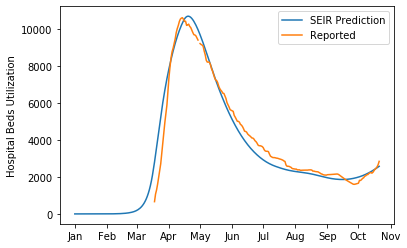

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


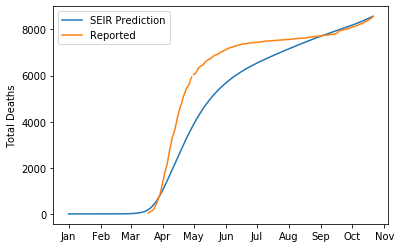

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


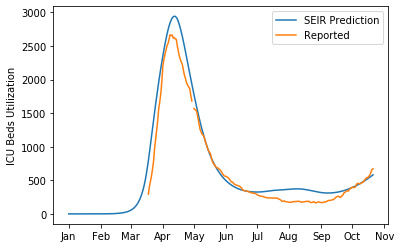

In [28]:
%matplotlib inline

plt.figure(1)
plt.plot(upper_days_model, model_data_beds["total"], label="SEIR Prediction")
plt.plot(upper_days_model, real_data_beds["total"], label="Reported")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
plt.ylabel("Hospital Beds Utilization")
plt.legend()
plt.savefig("beds.eps")
plt.show()

plt.figure(1)
plt.plot(upper_days_model, model_data_deaths["total"], label="SEIR Prediction")
plt.plot(upper_days_model, real_data_deaths["total"], label="Reported")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
plt.ylabel("Total Deaths")
plt.legend()
plt.savefig("deaths.eps")
plt.show()

plt.figure(1)
plt.plot(upper_days_model, model_data_icus["total"], label="SEIR Prediction")
plt.plot(upper_days_model, real_data_icus["total"], label="Reported")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
plt.ylabel("ICU Beds Utilization")
plt.legend()
plt.savefig("icus.eps")
plt.show()

In [9]:
with open("../parameters/Ile-de-France.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)

# Modify parameters
universe_params['mixing'] = {
    "name":"mult",
    "param_alpha":float(alpha_mixing),
    "param_beta":float(alpha_mixing),
}
universe_params['upper_bounds'] = {
    "transport":1.0,
    "leisure":1.0,
    "other":1.0,
    "school":1.0,
    "home":1.0,
    "work":1.0
}
# Modify beta
for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]['parameters']['beta'] = [beta_masks for t in range(720)]

new_p_ICU = initial_params["p_ICU"]*fraction_p_ICU
new_p_H = (initial_params["p_H"]+initial_params["p_ICU"])-(initial_params["p_ICU"]*fraction_p_ICU)

new_lambda_H = initial_params["lambda_H"]*change_lambda_H_aft
new_lambda_ICU = initial_params["lambda_ICU"]*change_lambda_ICU_aft
new_p_death = initial_params["p_death"]*change_p_death_aft

new_lambda_H_D = new_p_death*new_lambda_H
new_lambda_H_R = (1-new_p_death)*new_lambda_H
new_lambda_ICU_D = new_p_death*new_lambda_ICU
new_lambda_ICU_R = (1-new_p_death)*new_lambda_ICU


for i,ag in enumerate(age_groups):
    universe_params['seir-groups'][ag]['parameters']['p_ICU'] = float(new_p_ICU[i])
    universe_params['seir-groups'][ag]['parameters']['p_H'] = float(new_p_H[i])
    universe_params['seir-groups'][ag]['parameters']['lambda_H_D'] = float(new_lambda_H_D[i])
    universe_params['seir-groups'][ag]['parameters']['lambda_H_R'] = float(new_lambda_H_R[i])
    universe_params['seir-groups'][ag]['parameters']['lambda_ICU_D'] = float(new_lambda_ICU_D[i])
    universe_params['seir-groups'][ag]['parameters']['lambda_ICU_R'] = float(new_lambda_ICU_R[i])
    del universe_params['seir-groups'][ag]['parameters']['p_ICU_cond_ss']
    del universe_params['seir-groups'][ag]['parameters']['p_death_cond_ss']
    
with open('../parameters/fitted.yaml', 'w') as file:
    yaml.dump(universe_params, file)
    
    


In [10]:
# Add economic value parameters
contrib = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="contributions_normal", index_col = 0)
gains = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="activity_levels_as_%_of_full", index_col = 0)

empl_params = {}
empl_params["v"] = {}
for age_group in age_groups:
    empl_params["v"][age_group] = {}
    for activity in econ_activities:
        empl_params["v"][age_group][activity] = float(contrib[age_group][activity])/365.0


In [11]:
from gurobipy import *

# Calculate l-april and l-may
l_april = np.mean([google['work'][i] for i in range(len(google)) if google['date'][i][0:7]=="2020-04"])
l_may = np.mean([google['work'][i] for i in range(len(google)) if google['date'][i][0:7]=="2020-05"])
print("april",l_april)
print("may",l_may)


eq_activities = ['leisure','other','school','transport']

m = Model()
nu = m.addVar(vtype=GRB.CONTINUOUS, name="nu", lb = 0)
gamma = m.addVar(vtype=GRB.CONTINUOUS, name="gamma", lb = 0)
epsilonp_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_1", lb = 0)
epsilonn_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_1", lb = 0)

m.addConstr(nu+gamma==1)
m.addConstr(
        nu*l_april  + gamma == 0.5851+epsilonp_1-epsilonn_1
)

m.setObjective(epsilonp_1+epsilonn_1)
m.update()
m.optimize()

empl_params['nu'] = 0.95*float(nu.x)
empl_params['gamma'] = float(gamma.x)
empl_params['eta'] = 0.05*float(nu.x)

print("nu",empl_params['nu'])
print("eta",empl_params['eta'])
print("gamma",empl_params['gamma'])

april 0.2131333333333333
may 0.36496774193548387
Using license file /Users/sergioacamelogomez/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 2 rows, 4 columns and 6 nonzeros
Model fingerprint: 0xd6780599
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
nu 0.5009171397102432
eta 0.026364059984749645
gamma 0.4727188003050071


In [12]:
# Calculate the schooling parameter
r = 0.03
schooling_param = {}
for age_group in age_groups:
    if age_group == "age_group_0_9":
        schooling_param[age_group] = (1+r)**(-15)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    elif age_group == "age_group_10_19":
        schooling_param[age_group] = 0.907*(1+r)**(-5)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    else:
        schooling_param[age_group] = 0
        
# Calculate the cost of death
econ_cost_death = {}
age_groups_n = [0,10,20,30,40,50,60,70,80]
for i,age_group in enumerate(age_groups):
    s = 0
    for tao in range(age_groups_n[i]+5,70):
        ag = "age_group_%d_%d"%(int(tao/10)*10,int(tao/10)*10+9)
        s+=(1+r)**(-(tao-age_groups_n[i]))*sum([empl_params["v"][ag][act] for act in econ_activities])*365
    econ_cost_death[age_group] = float(s)

In [13]:
upper_bounds = {
    "transport":1.0,
    "leisure":1.0,
    "other":1.0,
    "school":1.0,
    "home":1.0,
    "work":1.0
}

econ_params = {
    "employment_params":empl_params,
    "schooling_params":schooling_param,
    "econ_cost_death":econ_cost_death,
    "upper_bounds":upper_bounds,
}
with open('../parameters/econ.yaml', 'w') as file:
    yaml.dump(econ_params, file)

In [14]:
def matrix_to_state(m):
    state = {}
    for i,age_group in enumerate(age_groups):
        state[age_group] = {}
        for j,c in enumerate(cont):
            state[age_group][c] = float(m[i,j])
    return state

with open('../initialization/oct21.yaml', 'w') as file:
    yaml.dump(matrix_to_state(final_state), file)